In [1]:
import json, os, math, sys, re, random
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm, trange
from pprint import pprint
import matplotlib.pyplot as plt 
import matplotlib


In [34]:
one = 'a'
zero = 'b'
delimiter = '='
count_range = range(1, 51)
count_range_ood = range(51, 99)
addon_range = range(1, 100)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
addon_prob = [1] * len(addon_range)
num_data = 1000000

In [59]:
# create training set
input_stats = np.zeros((len(count_range), len(addon_range)))
output_stats = np.zeros(len(addon_range))
data = []
for i in trange(num_data):
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    data.append([one] * count + [str(addon), delimiter, str(addon+count)])
    input_stats[count-1, addon-1] += 1
    output_stats[addon+count-1] += 1

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:07<00:00, 128892.46it/s]


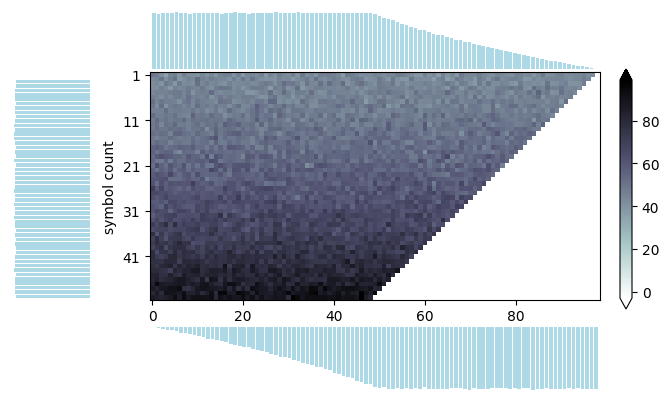

In [60]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

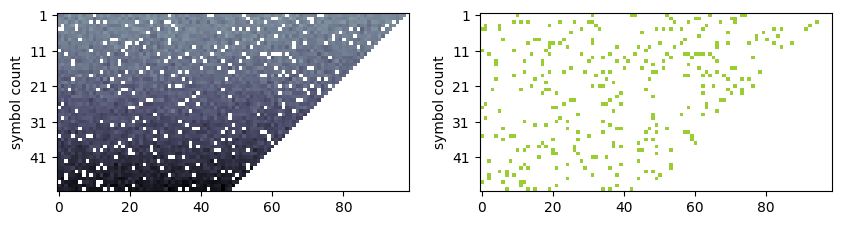

In [61]:
# create val set
num_val = 300
input_stats_val = np.zeros_like(input_stats)
numr, numc = input_stats.shape
for i in random.sample(list(np.flatnonzero(input_stats)), num_val):
    r, c = i//numc, i%numc
    input_stats_val[r, c] += 1
    input_stats[r, c] = 0

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellowgreen"])
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.imshow(input_stats, cmap='bone_r', interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')

ax = fig.add_subplot(122)
ax.imshow(input_stats_val, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')


plt.show()

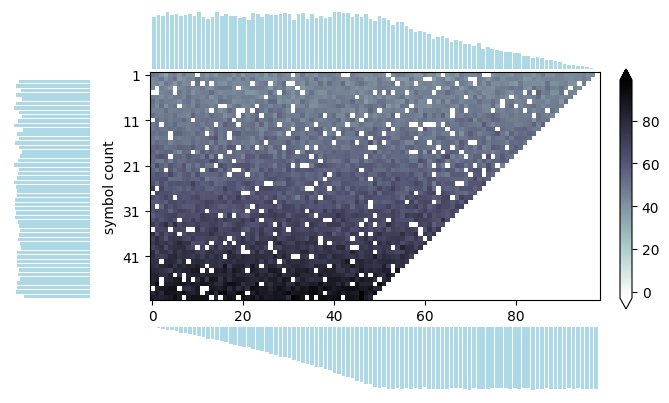

In [62]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

In [9]:
input_stats = np.zeros((len(count_range_ood), len(addon_range)))
output_stats = np.zeros(len(addon_range))
data_ood = []
for count in count_range_ood:
    for addon in addon_range[:-count]:
        data_ood.append([one] * count + [str(addon), delimiter, str(addon+count)])
        input_stats[count-count_range_ood[0], addon-1] += 1
        output_stats[addon+count-1] += 1
# for i in trange(num_data):
#     count = random.choices(count_range_ood, count_ood_prob)[0]
#     addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
#     data_ood.append([one] * count + [str(addon), delimiter, str(addon+count)])
#     input_stats[count-count_range_ood[0], addon-1] += 1
#     output_stats[addon+count-1] += 1


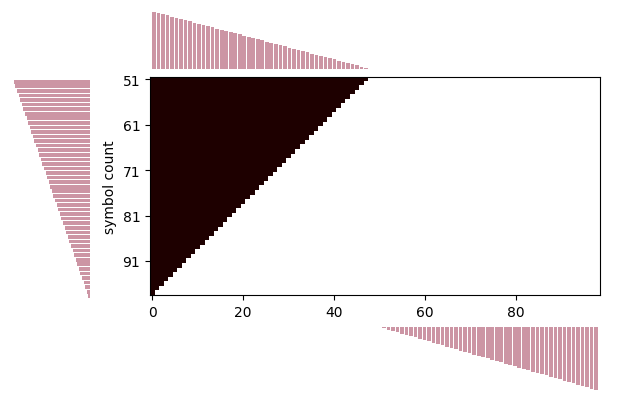

In [24]:
fig = plt.figure(figsize=(10, 6))
bar_color = '#cc95a4'
cmap = 'pink_r'
ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range_ood), 10), count_range_ood[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

# ax = plt.axes([0.67, 0.32, 0.15, 0.4])
# norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
# cbar = ax.figure.colorbar(
#             matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
#             ax=ax, pad=.05, extend='both', fraction=1)
# ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range_ood, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

plt.show()